# multi omic data integration

In [1]:
import os
#os.chdir('/home/xli')
os.getcwd()

'/home/xli/Data/Haihui/CD8-HP/Analysis_Notebook'

In [2]:
# Data Analysis
import numpy as np
import pandas as pd
from pybedtools import BedTool

# Plot Package
import matplotlib
#matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline


In [3]:
### Define .bed8 as following 
#chr	start	end	id	logFC	strand	pin	FDR
import networkx as nx
import dgl

In [3]:
def union_all_features(Path_Features_Folder, summit_or_normal):
    ## find all features inside given path
    Path_Feature_list=[]
    for file in os.listdir(Path_Features_Folder):
        if (file.endswith(".bed8")):
            Path_Feature_list.append(Path_Features_Folder+'/'+file)
    
    ## union them all
    i=0
    if (summit_or_normal=='summit'):
        for Path_Feature in Path_Feature_list:
            df_feature = pd.read_csv(Path_Feature,sep="\t")
            if(min(df_feature['pin'])==0):
                print ("ERR: File " + Path_Feature + "has wrong summit, check!")
                exit
            else:
                df_feature['start'] = df_feature['pin']-1
                df_feature['end'] = df_feature['pin']
                feature_add = BedTool.from_dataframe(df_feature)
                if(i==0):
                    feature_union = feature_add
                else:
                    feature_union = feature_union.cat(feature_add,postmerge=False)
                i+=1
    else:
        for Path_Feature in Path_Feature_list:
            feature_add=BedTool(Path_Feature)
            if(i==0):
                feature_union = feature_add
            else:
                feature_union = feature_union.cat(feature_add,postmerge=False)
            i+=1
    return feature_union.sort()

def associated_features_with_genes(feature_target, union_features, number_features_per_gene):
    # Gene Path, Target

    ## Features union
    features_closest_associated=feature_target.closest(union_features, k=number_features_per_gene, d=True, D='a')
    #"a"     Report distance with respect to A.  When A is on the - strand, "upstream" means B has a higher (start,stop).

    #df_features_closest_associated=pd.read_csv(features_20_closest_associated.fn, header=None, sep="\t")
    return features_closest_associated.fn

def features_visualization_on_gene(df_group, gene_name, num_columns_target, fc_label):
    df_inside_gene = df_group.get_group(gene_name) ##
    Gene_Expression_FC = df_inside_gene.iloc[0,4]
    df_inside_gene = df_inside_gene.iloc[:, num_columns_target:]
    ## data inside gene format, actually ignore gene part, then, still 3 should be id.
    df_subgroup_inside_gene = df_inside_gene.iloc[:, 3].str.split('_',  expand=True).groupby([0])
    # group by first part of id, normally is the category
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))

    color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','black'] 
    ## Maxium 10 features
    boundary_limit=0
    list_item_legend=[]
    list_name_legend=[]
    i=0
    j=0
    ## assuming fifth columns score, is Log2(FC)
    for feature_type in df_subgroup_inside_gene.groups.keys():
        Enlargement_Constant=200
        df_feature_tem = df_inside_gene.loc[df_subgroup_inside_gene.get_group(feature_type).index,:] 
        x_coordinate=df_feature_tem.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
        boundary_limit = max(boundary_limit, max(max(x_coordinate),abs(min(x_coordinate))))
        
        if(feature_type in fc_label):
            if(feature_type=='SE'): Enlargement_Constant=1000              
#############################################################################################
            ### This line is like the fold change = 1 line, 
            ax.plot([-boundary_limit,boundary_limit],[j,j], c=color[i], linestyle='--', lw=1, label=feature_type+"fold_change=1")
#############################################################################################
            df_feature_tem_fc_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)>0]  ## fifth columns is score
            x_coordinate= df_feature_tem_fc_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
            y_coordinate= df_feature_tem_fc_1.iloc[:,4].astype(float) ## corresponding to score part
            marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
            im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j+0.5, s=marker_size,  marker='^', c=color[i], alpha=0.8)
            list_item_legend.append(im)
            list_name_legend.append(feature_type+'_Up')
#############################################################################################    
            df_feature_tem_fc_less_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)<0]
            x_coordinate= df_feature_tem_fc_less_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
            y_coordinate= df_feature_tem_fc_less_1.iloc[:,4].astype(float) ## corresponding to score part
            marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
            im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j-0.5, s=marker_size, marker='v' , c=color[i], alpha=0.8)
            list_item_legend.append(im)
            list_name_legend.append(feature_type+'_Down')
            j+=1
            print (j)
####################################################################################
        else:
            #y_coordinate=np.log2(df_feature_tem.iloc[:,4].astype(float))  ## corresponding to score part
            y_coordinate=(df_feature_tem.iloc[:,4].astype(float))
            im=ax.scatter(x_coordinate, y_coordinate, s=Enlargement_Constant, c=color[i],  marker='^')
            list_item_legend.append(im)
            list_name_legend.append(feature_type)
        i+=1
        ## color code +1
####################################################################################
    legend_object = ax.legend(list_item_legend,list_name_legend, loc="upper right", scatterpoints=1,bbox_to_anchor=(0.50,1, 1,0),
            edgecolor='w', borderaxespad=0, fancybox=True, shadow=False,  fontsize=18, labelspacing=1.0)
    x=[-boundary_limit,0,boundary_limit]
    ax.set_xticks(x)
    customized_xticks=[ 'Upstream: '+ str(x[0]) ,'TSS of '+gene_name,'Downstream: +' + str(x[2])]
    ax.set_xticklabels(customized_xticks, fontsize=18)
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_ylabel("Peaks_Strength (Scale: Log2)", fontsize=18)
    #ax.set_ylim(-3,10)
    ax.set_title('Expression Log2(Fold Change): '+ str(Gene_Expression_FC) + " # of features: " + str(len(df_inside_gene)), fontsize=18)
    return None

In [18]:
df_target.head(1)
df_target[df_target['name']=='Myb']

,#chr,start,end,name,log2(fold_change),strand,pin,q_value,WT_0h,DKO_0h
1401,chr10,20880790,20880791,Myb,-5.82914,-,20880790,0.000315,13.5569,0.238459


In [4]:
#Union Features
Path_Features = "/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/Summary"
union_features = union_all_features(Path_Features,'nosummit')
## Prepare Target genes
Path_Target=Path_Features+'/Target/24391_Target_mm9_genes_with_strand.bed'
df_target = pd.read_csv(Path_Target, sep="\t")
df_target['start'] =  df_target['pin']
df_target['end'] =  df_target['pin']+1
Feature_Target=BedTool.from_dataframe(df_target).sort()

##Associated by closest 
Path_Associated_featuers = associated_features_with_genes(Feature_Target, union_features, 20)
df_group=pd.read_csv(Path_Associated_featuers, header=None, sep="\t").groupby([3]) # the fourth columns is geneid

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1
2


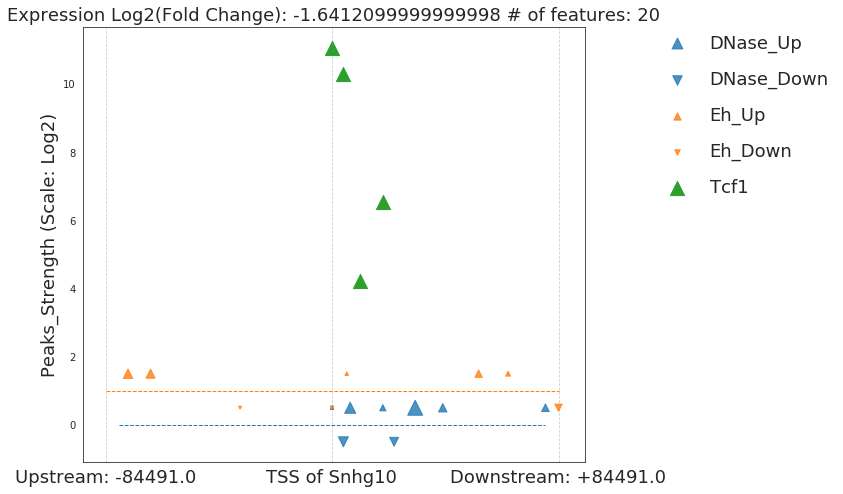

In [19]:
## summit
gene_list=['Ramp3', 'Snhg10', 'Il3ra', 'Cd200', 'App', 'Anxa5', 'Il6ra', 'Cryz', 'Abhd8']

gene_name='Snhg10'
features_visualization_on_gene(df_group, gene_name, len(df_target.columns), ['DNase', 'Eh' , 'SE'])

In [14]:
## Star Graph
from sklearn.preprocessing import LabelEncoder
import torch as th

In [12]:
gene_list=['Ramp3', 'Snhg10', 'Il3ra', 'Cd200', 'App', 'Anxa5', 'Il6ra', 'Cryz', 'Abhd8']
gene_name=gene_list[0]

Number_features_per_gene = 20

num_columns_target = len(df_target.columns)

#chr	start	end	id	logFC	strand	pin	FDR	distance

for gene_name in gene_list:
    df_inside_gene = df_group.get_group(gene_name).iloc[0:Number_features_per_gene]
    Gene_Expression_FC = df_inside_gene.iloc[0,4]
    df_inside_gene = df_inside_gene.iloc[:, num_columns_target:]
    ## data inside gene format, actually ignore gene part, then, still 3 should be id.
    df_feature_inside_gene = df_inside_gene.iloc[:, 3].str.split('_',  expand=True)
    
    print (df_inside_gene.shape)
    break
    
df_inside_gene.insert(len(df_inside_gene.columns),'type',df_feature_inside_gene.iloc[:,0])

### Encoding categroy to number
df_inside_gene['category']= LabelEncoder().fit_transform(df_feature_inside_gene.iloc[:,0])

(20, 9)


# Create a graph

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


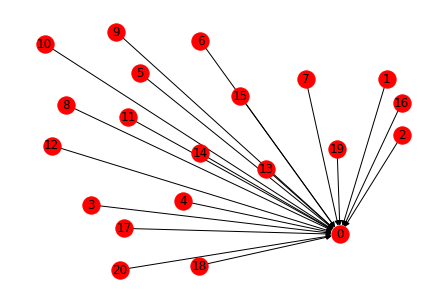

In [15]:
## Generate a graph
g = dgl.DGLGraph()
## 
Num_Nodes= 21
g.add_nodes(Num_Nodes)

g.nodes[0].data['score'] = th.tensor([[Gene_Expression_FC]])

## Add edges one-by-one
for i in range(1, Num_Nodes):
    fc_edge = df_inside_gene.iloc[i-1,[4]].values.astype('float')
    fdr_edge = df_inside_gene.iloc[i-1,[7]].values.astype('float')
    dist_edge = df_inside_gene.iloc[i-1,[8]].values.astype('int')
    category_edge = df_inside_gene.iloc[i-1,[10]].values.astype('int')
    
    g.add_edge(i, 0, {'dist': th.tensor([[dist_edge]]), 'fc': th.tensor([[fc_edge]]), 
        'fdr': th.tensor([[fdr_edge]]), 'category': th.tensor([[category_edge]])}) #Add one new edge between i and 0.
    
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

In [38]:
#logFC	strand	pin	FDR
#df_data_set = 

#df_inside_gene.iloc[:,3] = df_feature_inside_gene.iloc[:,0]
#df_inside_gene.iloc[:,[3,4,7,8]]

1
2
3


Text(0.5, 1.0, 'Expression Log2(Fold Change): -1.48012')

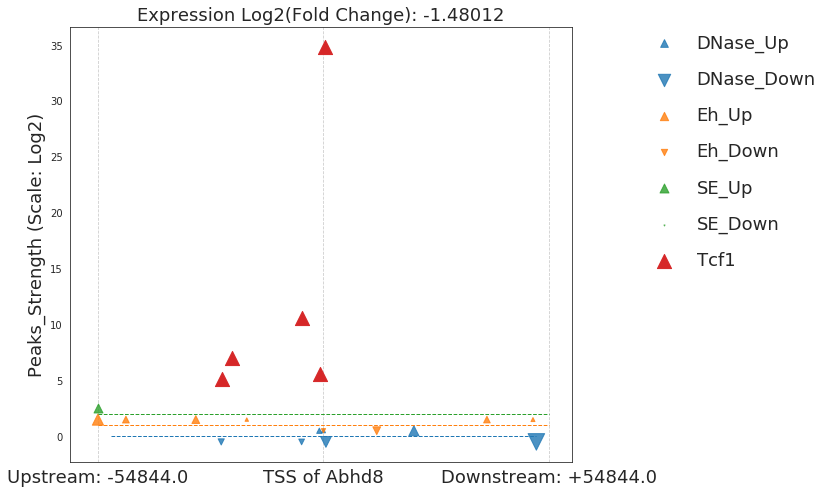

In [50]:
gene_name='Abhd8'
df_inside_gene = df_group.get_group(gene_name).iloc[:,10:]
df_inside_gene = df_inside_gene[13].str.split('_',  expand=True).groupby([0])

num_columns_target=len(df_target.columns)

fc_label = ['DNase', 'Eh' , 'SE']


df_inside_gene = df_group.get_group(gene_name) ##
Gene_Expression_FC = df_inside_gene.iloc[0,4]
df_inside_gene = df_inside_gene.iloc[:, num_columns_target:]
## data inside gene format, actually ignore gene part, then, still 3 should be id.
df_subgroup_inside_gene = df_inside_gene.iloc[:, 3].str.split('_',  expand=True).groupby([0])
# group by first part of id, normally is the category
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,8))

color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','black'] 
## Maxium 10 features
boundary_limit=0
list_item_legend=[]
list_name_legend=[]
i=0
j=0
## assuming fifth columns score, is Log2(FC)
for feature_type in df_subgroup_inside_gene.groups.keys():
    Enlargement_Constant=200
    df_feature_tem = df_inside_gene.loc[df_subgroup_inside_gene.get_group(feature_type).index,:] 
    x_coordinate=df_feature_tem.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
    boundary_limit = max(boundary_limit, max(max(x_coordinate),abs(min(x_coordinate))))

    if(feature_type in fc_label):
        if(feature_type=='SE'): Enlargement_Constant=1000              
#############################################################################################
        ### This line is like the fold change = 1 line, 
        ax.plot([-boundary_limit,boundary_limit],[j,j], c=color[i], linestyle='--', lw=1, label=feature_type+"fold_change=1")
#############################################################################################
        df_feature_tem_fc_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)>0]  ## fifth columns is score
        x_coordinate= df_feature_tem_fc_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
        y_coordinate= df_feature_tem_fc_1.iloc[:,4].astype(float) ## corresponding to score part
        marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j+0.5, s=marker_size,  marker='^', c=color[i], alpha=0.8)
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Up')
#############################################################################################    
        df_feature_tem_fc_less_1 = df_feature_tem[df_feature_tem.iloc[:,4].astype(float)<0]
        x_coordinate= df_feature_tem_fc_less_1.iloc[:,len(df_feature_tem.columns)-1].astype(float) ## last columns is distance to Target
        y_coordinate= df_feature_tem_fc_less_1.iloc[:,4].astype(float) ## corresponding to score part
        marker_size = [round(x) for x in abs(y_coordinate.astype(float)*Enlargement_Constant)]
        im=ax.scatter(x_coordinate, np.zeros(len(x_coordinate))+j-0.5, s=marker_size, marker='v' , c=color[i], alpha=0.8)
        list_item_legend.append(im)
        list_name_legend.append(feature_type+'_Down')
        j+=1
        print (j)
####################################################################################
    else:
        #y_coordinate=np.log2(df_feature_tem.iloc[:,4].astype(float))  ## corresponding to score part
        y_coordinate=(df_feature_tem.iloc[:,4].astype(float))
        im=ax.scatter(x_coordinate, y_coordinate, s=Enlargement_Constant, c=color[i],  marker='^')
        list_item_legend.append(im)
        list_name_legend.append(feature_type)
    i+=1
    ## color code +1
####################################################################################
legend_object = ax.legend(list_item_legend,list_name_legend, loc="upper right", scatterpoints=1,bbox_to_anchor=(0.50,1, 1,0),
        edgecolor='w', borderaxespad=0, fancybox=True, shadow=False,  fontsize=18, labelspacing=1.0)
x=[-boundary_limit,0,boundary_limit]
ax.set_xticks(x)
customized_xticks=[ 'Upstream: '+ str(x[0]) ,'TSS of '+gene_name,'Downstream: +' + str(x[2])]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
ax.set_ylabel("Peaks_Strength (Scale: Log2)", fontsize=18)
#ax.set_ylim(-3,10)
ax.set_title('Expression Log2(Fold Change): '+ str(Gene_Expression_FC), fontsize=18)





In [82]:
def gene_associated_multi_feature_tcf1(gene_annotation_path, feature_path, feature_RPKM_path, tcf1_feature_path, expression_path, genelist_set_for_plot):
    ## Genes 
    gene_annotation_Bed=BedTool(gene_annotation_path).sort()
    ## Features To be associated
    features_Bed=BedTool(feature_path).sort()
    ## Add Tcf1
    Tcf1_Peak_Bed=BedTool(tcf1_feature_path)
    features_Bed_with_Tcf1=features_Bed.intersect(Tcf1_Peak_Bed,c=True)
    ## Associated Rule report ties
    features_associated=features_Bed_with_Tcf1.closest(gene_annotation_Bed, t='all')
    df_features_associated=pd.read_table(features_associated.fn, header=None)
    ## Group by gene_id
    df_genes_with_features=df_features_associated.groupby(8) ## in some cases, 7 columns is gene_id
    ## add expression
    df_gene_expression=generate_All_Genes(path_of_expression,0)
    ### in here, feature coordinates are seperate file from RPKM
    df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
    
    j=0
    for gene_set_name in genelist_set.keys():
        print gene_set_name
        df_genelist_set=pd.DataFrame({'gene_id':genelist_set[gene_set_name]})
        df_gene_expression_tem=df_gene_expression.merge(df_genelist_set, on='gene_id', how='inner')
        i=0
        for genelist in df_gene_expression_tem.sort_values('log2(fold_change)')['gene_id']:
            if(genelist not in df_features_associated[8].unique()):
                continue
            group=df_genes_with_features.get_group(genelist)
            gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID', 4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')


            x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
            y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
            gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
            im=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc,
                          c=gene_associated_DNase['logFC'],
                        vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
            im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
                vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
            ax.text(i,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
            i+=1
        ax.text(len(genelist_set[genelist_set.keys()[j]])/2, gene_expression_fc-1, 'Genelists: '+ str(len(genelist_set[genelist_set.keys()[j]])), fontsize=12, color='r')   
        j+=1
    im_zero = ax.plot(np.arange(i),np.zeros(i), '--', linewidth=1)
    ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
    ax.legend([im,im_Tcf1], ['DNase_Site','Tcf1_Binding'], scatterpoints=1,loc=0, fontsize=14)
    fig.colorbar(im,ax=ax)
    return df_features_associated

# Prepare for Peng Feature

### On Promoter

In [4]:
PATH_Feature_Folder="/home/xli/Data/Haihui/CD8-HP/Summary/"
Path_gene_annotation=PATH_Feature_Folder+"gene_promoter_1k_iv_unique.bed"

gene_annotation_Bed=BedTool(Path_gene_annotation).sort()
Feature_A = BedTool(PATH_Feature_Folder+"A_28827_Feature_Union_Naive_DNase_Peaks.bed8").sort()
Feature_B = BedTool(PATH_Feature_Folder+"B_19042_Feature_Tcf1_WT_CD8_peaks.bed8").sort()
Feature_C = BedTool(PATH_Feature_Folder+"C_76633_Pooled_K27ac_with_EdgeR.bed").sort()
Feature_D = BedTool(PATH_Feature_Folder+"D_1190_Union_SE_with_EdgeR_with_Tcf1_score_in_Peaks.bed").sort()

In [27]:
promoter_with_A = gene_annotation_Bed.intersect(Feature_A, wao=True)
promoter_with_A_B = promoter_with_A.intersect(Feature_B, wao=True)
promoter_with_A_B_C = promoter_with_A_B.intersect(Feature_C, wao=True)
df_promoter_with_A_B_C = pd.read_csv(promoter_with_A_B_C.fn, sep="\t", header=None)
df_promoter_with_A_B_C = df_promoter_with_A_B_C.iloc[:,[0,1,2,3,4,9,12,18,27,30]].rename(columns={9:'DNase_logFC',12:'DNase_FDR', 18:'Tcf1_Enrichment', 27:'K27Ac_logFC',30:'K27Ac_FDR'}) ##9 DNase logFC, #18 Tcf1 log Enrichment # 27 K27ac logFC

In [21]:
df_promoter_with_A_B_C.head(1)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,chr1,3660578,3662579,Xkr4,promoter,.,-1,-1,.,.,...,0,.,-1,-1,.,.,.,.,.,0


In [29]:
Path_gene_expression = PATH_Feature_Folder+"Target/24391_Target_mm9_genes_with_strand.bed"
df_gene_expression = pd.read_csv(Path_gene_expression, sep="\t", header=0)
df_promoter_with_A_B_C.merge(df_gene_expression.loc[:,['name','log2(fold_change)','WT_0h', 'DKO_0h','q_value']].rename(columns={'log2(fold_change)':'Expression_log2FC'}), left_on=3, right_on='name', how='inner').drop(columns='name').head(3)

,0,1,2,3,4,DNase_logFC,DNase_FDR,Tcf1_Enrichment,K27Ac_logFC,K27Ac_FDR,Expression_log2FC,WT_0h,DKO_0h,q_value
0,chr1,3660578,3662579,Xkr4,promoter,.,.,.,.,.,0.0,0.0,0.0,1.0
1,chr1,4349394,4351395,Rp1,promoter,.,.,.,.,.,0.0,0.0,0.0,1.0
2,chr1,4486434,4488435,Sox17,promoter,.,.,13.71085,0.22484602396160056,0,0.0,0.0,0.0,1.0


## On Tcf1/DNase

In [32]:
PATH_Feature_Folder="/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq_ChIP_seq_HiC/Features/Summary_Files/"
Path_gene_annotation=PATH_Feature_Folder+"31946_Tcf1_DNase_Enhancer.bed"

gene_annotation_Bed=BedTool(Path_gene_annotation).sort()
Feature_A = BedTool(PATH_Feature_Folder+"A_28827_Feature_Union_Naive_DNase_Peaks.bed8").sort()
Feature_B = BedTool(PATH_Feature_Folder+"B_19042_Feature_Tcf1_WT_CD8_peaks.bed8").sort()
Feature_C = BedTool(PATH_Feature_Folder+"C_64806_Feature_Union_Naive_K27Ac_Enhancer_fc.bed8").sort()

promoter_with_A = gene_annotation_Bed.intersect(Feature_A, wao=True)
promoter_with_A_B = promoter_with_A.intersect(Feature_B, wao=True)
promoter_with_A_B_C = promoter_with_A_B.intersect(Feature_C, wao=True)
df_promoter_with_A_B_C = pd.read_csv(promoter_with_A_B_C.fn, sep="\t", header=None)
df_promoter_with_A_B_C = df_promoter_with_A_B_C.iloc[:,[0,1,2,3,4,9,12,18,27,30]].rename(columns={9:'DNase_logFC',12:'DNase_FDR', 18:'Tcf1_Enrichment', 27:'K27Ac_logFC',30:'K27Ac_FDR'}) ##9 DNase logFC, #18 Tcf1 log Enrichment # 27 K27ac logFC

In [34]:
df_promoter_with_A_B_C.head(5)

,0,1,2,3,4,DNase_logFC,DNase_FDR,Tcf1_Enrichment,K27Ac_logFC,K27Ac_FDR
0,chr1,4486300,4486819,Enhancer,Eh_1,.,.,13.71085,0.22484602396160056,0
1,chr1,4758612,4758821,Enhancer,Eh_2,0.4320268345724,0.640734983244517,.,.,.
2,chr1,4770212,4770354,Enhancer,Eh_3,0.41872326825376005,0.8796002751890271,.,.,.
3,chr1,4775547,4776053,Enhancer,Eh_4,-0.11899379761593999,0.837738110805253,9.65992,-0.39606515932192393,0
4,chr1,4797719,4798201,Enhancer,Eh_5,-0.350631241459532,0.57149475039038,5.9206,-0.49277374108487787,0


In [ ]:
Path_gene_expression = PATH_Feature_Folder+"Target/24391_Target_mm9_genes_with_strand.bed"
df_gene_expression = pd.read_csv(Path_gene_expression, sep="\t", header=0)
df_promoter_with_A_B_C.merge(df_gene_expression.loc[:,['name','log2(fold_change)','WT_0h', 'DKO_0h','q_value']].rename(columns={'log2(fold_change)':'Expression_log2FC'}), left_on=3, right_on='name', how='inner').drop(columns='name').head(3)

In [ ]:
df_for_category=df_feature_associated_genes_with_genes
df_group = df_for_category.groupby([8])
genelist_to_be_removed=list()
for group_item in df_group:
    size_group = len(group_item[1])
    if (size_group>1):
        if (len(group_item[1]['SuperEnhancer'].value_counts()) > 1):
            genelist_to_be_removed.append(group_item[0])
print ("Genes with Ambiguity: " + str(len(genelist_to_be_removed)))

In [ ]:
features_closest_associated=features_no_overlap.closest(gene_annotation_Bed, t='all')

In [35]:
from pybedtools import example_bedtool
a = example_bedtool('a.bed')
b = example_bedtool('b.bed')
print (a)
print (b)
print (a.cat(b, postmerge=False))

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+

chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+

chr1	1	100	feature1	0	+
chr1	100	200	feature2	0	+
chr1	150	500	feature3	0	-
chr1	900	950	feature4	0	+
chr1	155	200	feature5	0	-
chr1	800	901	feature6	0	+

